In [1]:
library(tidyverse)
library(ggplot2)
options(repr.matrix.max.rows = 20)
library(boot)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
# download and simplify the bee dataset

bees <- read.csv("https://files.ontario.ca/moe_mapping/downloads/4Other/PHAP/Bumble_Bee_Public_Data.csv") |>
    select(1:7, contains("total")) |>
    mutate(site_type = case_when(`Site.Type` == "Agri" ~ "Agricultural",
                                 `Site.Type` == "Agriculture" ~ "Agricultural",
                                 TRUE ~ `Site.Type`)) |>
    rename(
        county = `ï..County`,
        site_id = `MOECC.Site.Number`,
        year = Year,
        sample_date = `Sample.date`) |>
    filter(site_type != "") |>
    pivot_longer(`bimaculatus.total`:`flavidus.total`,
                 values_to = "no_of_bees", names_to = "species") |>
    select(county, year, site_id, site_type, no_of_bees, sample_date)

bee_df <- bees |>
    group_by(site_id, site_type) |>
    summarise(bees_per_site = sum(no_of_bees)) |>
    arrange(site_id)
bees

`summarise()` has grouped output by 'site_id'. You can override using the `.groups` argument.



county,year,site_id,site_type,no_of_bees,sample_date
<chr>,<int>,<int>,<chr>,<int>,<chr>
Middlesex Centre,2015,1,Agricultural,7,07/02/2015
Middlesex Centre,2015,1,Agricultural,1,07/02/2015
Middlesex Centre,2015,1,Agricultural,3,07/02/2015
Middlesex Centre,2015,1,Agricultural,0,07/02/2015
Middlesex Centre,2015,1,Agricultural,1,07/02/2015
Middlesex Centre,2015,1,Agricultural,0,07/02/2015
Middlesex Centre,2015,1,Agricultural,0,07/02/2015
Middlesex Centre,2015,1,Agricultural,1,07/02/2015
Middlesex Centre,2015,1,Agricultural,0,07/02/2015


In [3]:
summary(bees)

    county               year         site_id       site_type        
 Length:3444        Min.   :2015   Min.   : 1.00   Length:3444       
 Class :character   1st Qu.:2015   1st Qu.:15.00   Class :character  
 Mode  :character   Median :2016   Median :26.00   Mode  :character  
                    Mean   :2016   Mean   :28.21                     
                    3rd Qu.:2017   3rd Qu.:41.00                     
                    Max.   :2017   Max.   :67.00                     
   no_of_bees      sample_date       
 Min.   :  0.000   Length:3444       
 1st Qu.:  0.000   Class :character  
 Median :  0.000   Mode  :character  
 Mean   :  1.259                     
 3rd Qu.:  0.000                     
 Max.   :113.000                     

In [4]:
glimpse(bees)

Rows: 3,444
Columns: 6
$ county      <chr> "Middlesex Centre", "Middlesex Centre", "Middlesex Centre"~
$ year        <int> 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015~
$ site_id     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2~
$ site_type   <chr> "Agricultural", "Agricultural", "Agricultural", "Agricultu~
$ no_of_bees  <int> 7, 1, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 14, 7, 0, 0, ~
$ sample_date <chr> "07/02/2015", "07/02/2015", "07/02/2015", "07/02/2015", "0~


In [5]:
table(bees$site_type)


        Agricultural              Natural Semi-natural remnant 
                1806                  658                  980 

Warning message:
"Removed 14 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 7 rows containing missing values (geom_bar)."


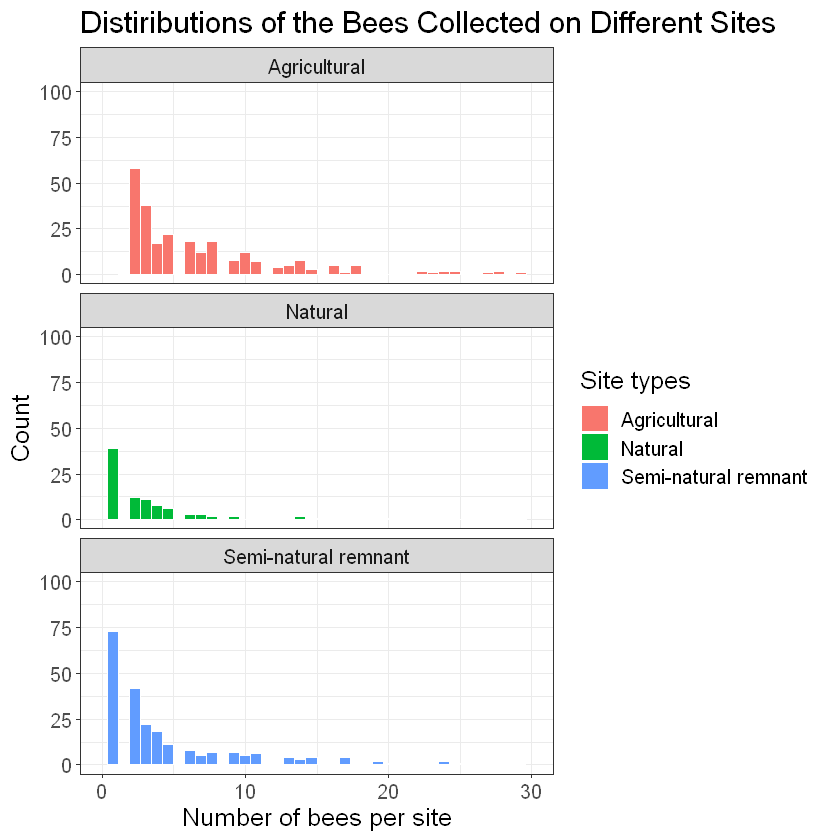

In [6]:
# Distiributions of the bees collected on different sites (Histogram)

bee_df_hist <- ggplot(bees) +
    aes(x = no_of_bees,
        fill = site_type) +
    geom_histogram(bins = 40, color = 'white') +
    facet_wrap(~site_type, ncol = 1) +
    labs(x = "Number of bees per site",
         y = "Count",
         fill = "Site types",
         title = "Distiributions of the Bees Collected on Different Sites"
         ) +
    xlim(0, 30) +
    ylim(0, 100) +
    theme_bw() +
    theme(text =  element_text(size = 15))
    
bee_df_hist

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 2716 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 2716 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 2716 rows containing non-finite values (stat_summary)."


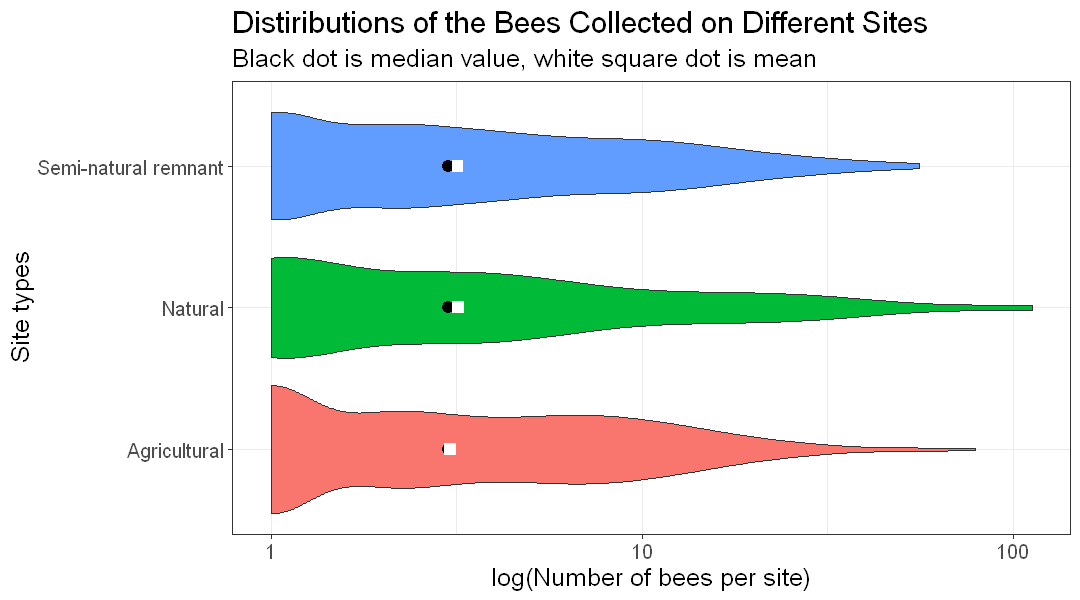

In [7]:
# Distiributions of the bees collected on different sites (Violin Plot with Mean)

options(repr.plot.width=9, repr.plot.height=5)

bee_df_plot <- ggplot(bees) +
    aes(y = site_type,
        x = no_of_bees,
        fill = site_type) +
    geom_violin() +
    geom_point(stat = "summary", fun = median, size = 3) +
    geom_point(stat = "summary", fun = mean, size = 3,
               shape = 15, color = "white") +
    scale_x_continuous(trans='log10') +
    labs(x = "log(Number of bees per site)",
         y = "Site types",
         fill = "Site types",
         title = "Distiributions of the Bees Collected on Different Sites",
         subtitle = "Black dot is median value, white square dot is mean"
         ) +
    guides(fill = "none") +
    theme_bw() +
    theme(text =  element_text(size = 15))

bee_df_plot